# Setup

In [ ]:
import os
from tqdm import tqdm
from typing import Any, Dict, Tuple, List, Optional, Union
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from astropy.constants import R_earth
from geexhp.modelfuncs import datasetup as dset
from geexhp import datavis
datavis.configure_matplotlib()

import glob
from itertools import chain

from collections import Counter

class TFRecordConfig:
    """
    Configuration for TFRecord conversion.
    """

    COLUMNS_OF_INTEREST: List[str] = [
        "ALBEDO_B-NIR",
        "ALBEDO_B-UV",
        "ALBEDO_B-Vis",

        "ALBEDO_SS-NIR",
        "ALBEDO_SS-UV",
        "ALBEDO_SS-Vis",

        "NOISY_ALBEDO_B-NIR",
        "NOISY_ALBEDO_B-UV",
        "NOISY_ALBEDO_B-Vis",

        "NOISY_ALBEDO_SS-NIR",
        "NOISY_ALBEDO_SS-UV",
        "NOISY_ALBEDO_SS-Vis",

        "NOISE_B-NIR",
        "NOISE_B-UV",
        "NOISE_B-Vis",

        "NOISE_SS-NIR",
        "NOISE_SS-UV",
        "NOISE_SS-Vis",

        "OBJECT-DIAMETER",
        "OBJECT-GRAVITY",
        "ATMOSPHERE-TEMPERATURE",
        "ATMOSPHERE-PRESSURE",
        
        "Earth_type",
        "OBJECT-STAR-TYPE",
        "GEOMETRY-OBS-ALTITUDE"
    ]

    MOLECULES: List[str] = [
        "C2H6",
        "CH4",
        "CO",
        "CO2",
        "H2O",
        "N2",
        "N2O",
        "O2",
        "O3",
    ]

    # SPECTRA: List[str] = [
    #     "NOISY_ALBEDO_B-NIR",
    #     "NOISY_ALBEDO_B-UV",
    #     "NOISY_ALBEDO_B-Vis",
    #     "NOISY_ALBEDO_SS-NIR",
    #     "NOISY_ALBEDO_SS-UV",
    #     "NOISY_ALBEDO_SS-Vis",
    # ]


def _bytes_feature(value: str) -> tf.train.Feature:
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))

def _float_feature(value: float) -> tf.train.Feature:
    """Returns a float_list from a float / list of floats."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _float_feature_list(value: List[float]) -> tf.train.Feature:
    """Returns a float_list from a float / list of floats."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _serialize_sample(row: Dict[str, Union[str, float, List[float]]]) -> bytes:
    """
    Serialize a single sample (row) into a tf.train.Example.
    """
    feature = {
        # SPECTRA
        "ALBEDO_B-NIR": _float_feature_list(row["ALBEDO_B-NIR"]),
        "ALBEDO_B-UV": _float_feature_list(row["ALBEDO_B-UV"]),
        "ALBEDO_B-Vis": _float_feature_list(row["ALBEDO_B-Vis"]),

        "ALBEDO_SS-NIR": _float_feature_list(row["ALBEDO_SS-NIR"]),
        "ALBEDO_SS-UV": _float_feature_list(row["ALBEDO_SS-UV"]),
        "ALBEDO_SS-Vis": _float_feature_list(row["ALBEDO_SS-Vis"]),

        "NOISY_ALBEDO_B-NIR": _float_feature_list(row["NOISY_ALBEDO_B-NIR"]),
        "NOISY_ALBEDO_B-UV": _float_feature_list(row["NOISY_ALBEDO_B-UV"]),
        "NOISY_ALBEDO_B-Vis": _float_feature_list(row["NOISY_ALBEDO_B-Vis"]),

        "NOISY_ALBEDO_SS-NIR": _float_feature_list(row["NOISY_ALBEDO_SS-NIR"]),
        "NOISY_ALBEDO_SS-UV": _float_feature_list(row["NOISY_ALBEDO_SS-UV"]),
        "NOISY_ALBEDO_SS-Vis": _float_feature_list(row["NOISY_ALBEDO_SS-Vis"]),

        "NOISE_B-NIR": _float_feature_list(row["NOISE_B-NIR"]),
        "NOISE_B-UV": _float_feature_list(row["NOISE_B-UV"]),
        "NOISE_B-Vis": _float_feature_list(row["NOISE_B-Vis"]),

        "NOISE_SS-NIR": _float_feature_list(row["NOISE_SS-NIR"]),
        "NOISE_SS-UV": _float_feature_list(row["NOISE_SS-UV"]),
        "NOISE_SS-Vis": _float_feature_list(row["NOISE_SS-Vis"]),

        # Main Features
        "OBJECT-RADIUS-REL-EARTH": _float_feature(row["OBJECT-RADIUS-REL-EARTH"]),
        "OBJECT-DIAMETER": _float_feature(row["OBJECT-DIAMETER"]),
        "OBJECT-GRAVITY": _float_feature(row["OBJECT-GRAVITY"]),
        "ATMOSPHERE-TEMPERATURE": _float_feature(row["ATMOSPHERE-TEMPERATURE"]),
        "ATMOSPHERE-PRESSURE": _float_feature(row["ATMOSPHERE-PRESSURE"]),

        "Earth_type": _bytes_feature(row["Earth_type"]),
        "OBJECT-STAR-TYPE": _bytes_feature(row["OBJECT-STAR-TYPE"]),
        "GEOMETRY-OBS-ALTITUDE": _float_feature(row["GEOMETRY-OBS-ALTITUDE"]),

        # Molecules
        "C2H6": _float_feature(row["C2H6"]),
        "CH4": _float_feature(row["CH4"]),
        "CO": _float_feature(row["CO"]),
        "CO2": _float_feature(row["CO2"]),
        "H2O": _float_feature(row["H2O"]),
        "N2": _float_feature(row["N2"]),
        "N2O": _float_feature(row["N2O"]),
        "O2": _float_feature(row["O2"]),
        "O3": _float_feature(row["O3"]),
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def _convert_to_earth_radius(data: float) -> float:
    """
    Convert diameter (in km) to Earth"s radii (relative).
    """
    return data / (2 * R_earth.to("km").value)

def create_tfrecords(root_folder: str, save_root: str) -> None:
    """
    Traverse a root folder containing subfolders of .parquet files, filter/transform
    the data, and write each filtered DataFrame to TFRecord files.

    Parameters
    ----------
    root_folder : str
        The path to the root directory containing subfolders with .parquet files.
    save_root : str
        The path to the directory where the TFRecord files will be saved.
    """

    file_count = sum(
        len([file for file in files if file.endswith(".parquet")])
        for _, _, files in os.walk(root_folder)
    )

    if not os.path.exists(save_root):
        os.makedirs(save_root)

    with tqdm(
        total=file_count,
        desc="🌍 Progress",
        dynamic_ncols=True,
        colour="cyan",
        bar_format="{desc}: |{bar:30}| {percentage:3.0f}% ({n_fmt}/{total_fmt} files) ⏳ [{elapsed} elapsed]"
    ) as pbar:
        # Iterate through each subfolder
        for folder in os.listdir(root_folder):
            folder_path = os.path.join(root_folder, folder)
            if not os.path.isdir(folder_path):
                continue  # Skip if not a directory

            files = os.listdir(folder_path)
            for file in files:
                if not file.endswith(".parquet"):
                    continue  # Skip non-parquet files

                file_path = os.path.join(folder_path, file)

                # Extract metadata from filename
                earth_type = file.split("_")[0]
                original_parquet_range = file.split("_")[1].split(".")[0]

                # Read parquet file
                df = pd.read_parquet(file_path)
                df["Earth_type"] = earth_type

                # Filter out rows with noise > 5
                noise_columns = [col for col in df.columns if "NOISE_" in col]
                mask = ~df[noise_columns].applymap(lambda x: any(value > 3 for value in x)).any(axis=1)
                df = df[mask]

                # Keep only columns of interest
                filtered_df = df.copy()
                filtered_df = filtered_df[TFRecordConfig.COLUMNS_OF_INTEREST]

                # Extract abundances
                df = dset.extract_abundances(df)

                # Additional derived features
                filtered_df["OBJECT-RADIUS-REL-EARTH"] = df["OBJECT-DIAMETER"].apply(_convert_to_earth_radius)

                for molecule in TFRecordConfig.MOLECULES:
                    if molecule in df.columns:
                        filtered_df[f"{molecule}"] = df[molecule]
                    else:
                        filtered_df[f"{molecule}"] = 0

                # Prepare dictionary records
                record_dict = filtered_df.to_dict(orient="records")

                # TFRecord filename
                tfrecord_file = f"{earth_type}_{folder}_{original_parquet_range}_{len(record_dict)}.tfrecord"
                save_path_file = os.path.join(save_root, tfrecord_file)

                # Serialize and write records
                with tf.io.TFRecordWriter(save_path_file) as writer:
                    for sample in record_dict:
                        serialized_sample = _serialize_sample(sample)
                        writer.write(serialized_sample)

                pbar.update(1)

: 

In [16]:
def concatenate_all_tfrecords(root_folder: str,output_tfrecord_file: str) -> None:
    """
    Concatenate all TFRecord files found under a given directory into a single TFRecord file.

    Parameters
    ----------
    root_folder : str
        The path to the directory containing TFRecord files.
    output_tfrecord_file : str
        The output file path (e.g. "../data/geexhp_samples.tfrecord") where all
        concatenated records will be stored.

    Returns
    -------
    None
        Writes a single TFRecord file at the specified output location.
    """
    # Recursively gather all TFRecord files under root_folder
    files_array = [
        [file for file in files if file.endswith('.tfrecord')]
        for _, _, files in os.walk(root_folder)
    ]
    all_files = list(chain.from_iterable(files_array))

    # Write concatenated records to a new TFRecord file
    with tf.io.TFRecordWriter(output_tfrecord_file) as writer:
        for tfrecord_file in all_files:
            tfrecord_file_path = os.path.join(root_folder, tfrecord_file)
            # Read each TFRecord file and write its records to the output
            for record in tf.data.TFRecordDataset(tfrecord_file_path):
                writer.write(record.numpy())

    print(f"Concatenated TFRecord file saved to '{output_tfrecord_file}'")

# New data

In [14]:
create_tfrecords(root_folder="../parallel_test/", save_root="teste/")

🌍 Progress: |██████████████████████████████| 100% (36/36 files) ⏳ [01:02 elapsed]


In [19]:
concatenate_all_tfrecords(root_folder="teste/", output_tfrecord_file="teste//samples.tfrecord")

2025-05-22 23:46:53.338619: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-22 23:46:53.360584: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-22 23:46:53.402738: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-22 23:46:53.487463: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-22 23:46:53.685014: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Concatenated TFRecord file saved to 'teste//samples.tfrecord'


2025-05-22 23:46:54.203202: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
TELESCOPE = {
    "LUVOIR": dict(prefix="B",
                   region_bins={"UV": 8,  "Vis": 94,  "NIR": 49}),
    "HABEX" : dict(prefix="SS",
                   region_bins={"UV": 7,  "Vis":109,  "NIR": 25}),
}

def parse_example(example_proto: tf.Tensor,
                  input_stats: Dict[str, Tuple[float, float]],
                  output_stats: Dict[str, Any],
                  telescope: str = "LUVOIR"):

    meta   = TELESCOPE[telescope]
    pfx    = meta["prefix"]
    bins   = meta["region_bins"]

    # 1) Define raw feature schemas.
    raw_input_features = {f'NOISY_ALBEDO_{pfx}-{r}': tf.io.VarLenFeature(tf.float32)
              for r in ['NIR','UV','Vis']}

    raw_output_features = {
        # Planetary parameters.
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY":           tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE":   tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE":      tf.io.FixedLenFeature([], tf.float32),

        # Chemical abundances.
        'CH4':  tf.io.FixedLenFeature([], tf.float32),
        'CO':   tf.io.FixedLenFeature([], tf.float32),
        'CO2':  tf.io.FixedLenFeature([], tf.float32),
        'H2O':  tf.io.FixedLenFeature([], tf.float32),
        'N2':   tf.io.FixedLenFeature([], tf.float32),
        'N2O':  tf.io.FixedLenFeature([], tf.float32),
        'O2':   tf.io.FixedLenFeature([], tf.float32),
        'O3':   tf.io.FixedLenFeature([], tf.float32),

        'Earth_type': tf.io.FixedLenFeature([], tf.string),
        'OBJECT-STAR-TYPE': tf.io.FixedLenFeature([], tf.string),
        'GEOMETRY-OBS-ALTITUDE': tf.io.FixedLenFeature([], tf.float32),
    }

    # 2) Parse the example.
    all_features = {**raw_input_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    # 3) Normalize input spectra.
    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        spectrum = parsed[f'NOISY_ALBEDO_{pfx}-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)

        mean = input_stats[region][0]
        std  = input_stats[region][1]
        normalized = (spectrum - mean) / std

        normalized   = tf.reshape(normalized, [bins[region], 1])
        normalized_inputs[f'NOISY_ALBEDO_{pfx}-{region}'] = normalized

    # 4) Process outputs.
    physical_outputs = []
    main_chemical_outputs = []
    other_chemical_outputs = []

    # 4a) Process planetary parameters (physical outputs).
    for param in ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]:
        val = parsed[param]
        # To avoid a very ponctual error we found
        # the floating point precision error generates a single NaN value here :(
        if val == 273.15:
            val += 0.00002
        min_  = output_stats['physical_output_stats'][param][0]
        max_  = output_stats['physical_output_stats'][param][1]
        best_n  = output_stats['physical_output_stats'][param][2]
        processed = (val - min_) / (max_ - min_)
        processed = tf.math.pow(float(processed), float(1/best_n))
        physical_outputs.append(processed)

    # 4b) Process main chemical abundances.
    for chem in ['O2', 'O3']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1/best_n))
        main_chemical_outputs.append(processed)

    # 4c) Process other chemical abundances.
    for chem in ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1 / best_n))
        other_chemical_outputs.append(processed)

    grouped_outputs = {
        'physical_output': physical_outputs,              # shape (4,)
        'main_chemical_output': main_chemical_outputs,    # shape (2,)
        'other_chemical_output': other_chemical_outputs,  # shape (7,)
        'earth_type': parsed['Earth_type'],
        'star_type': parsed['OBJECT-STAR-TYPE'],
        'obs_altitude': parsed['GEOMETRY-OBS-ALTITUDE'],
    }

    return normalized_inputs, grouped_outputs


def read_tfrecord(file_path: str,
                  telescope: str = "LUVOIR",
                  batch_size: int = 1024,
                  shuffle_buffer: Optional[int] = None,
                  repeat: bool = False):

    meta  = TELESCOPE[telescope]
    pfx   = meta["prefix"]

    with open('/home/sarah/Documentos/PSGCode/data/normalization_stats.json') as f:
        stats = json.load(f)

    # Create lookup dictionaries for input normalization statistics.
    input_stats = {r: (stats['inputs'][f'{pfx}-{r}']['mean'],
                       stats['inputs'][f'{pfx}-{r}']['std'])
                   for r in ['UV','Vis','NIR']}

    physical_keys = ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]
    physical_output_stats = {
        key: (stats['outputs'][key]['min'], stats['outputs'][key]['max'], stats['outputs'][key]['best_n'])
        for key in physical_keys
    }

    chemical_keys = ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O', 'O2', 'O3']
    chemical_output_stats = {
        key: stats['outputs'][key] for key in chemical_keys
    }

    output_stats: Dict[str, Any] = {
        'physical_output_stats': physical_output_stats,
        'chemical_output_stats': chemical_output_stats
    }

    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if shuffle_buffer is not None and shuffle_buffer > 0:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Parse the dataset using the parse_example function.
    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats, telescope=telescope),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if repeat:
        parsed_dataset = parsed_dataset.repeat()

    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)

    return parsed_dataset

In [5]:
luvoir_ds  = read_tfrecord("/home/sarah/Documentos/PSGCode/examples/teste/samples.tfrecord", telescope="LUVOIR", batch_size=1)
habex_ds  = read_tfrecord("/home/sarah/Documentos/PSGCode/examples/teste/samples.tfrecord", telescope="HABEX", batch_size=1)

In [23]:
def collect_star_and_altitude(ds, max_batches=None):
    star, alt = [], []
    for n, (_, g) in enumerate(ds.unbatch()):
        star.append(g['star_type'].numpy().decode())
        alt.append(float(g['obs_altitude'].numpy()))
        
        if max_batches and n + 1 >= max_batches:
            break
    return star, alt

In [24]:
star_types, obs_altitude = collect_star_and_altitude(luvoir_ds)
star_types_habex, obs_altitude_habex = collect_star_and_altitude(habex_ds)

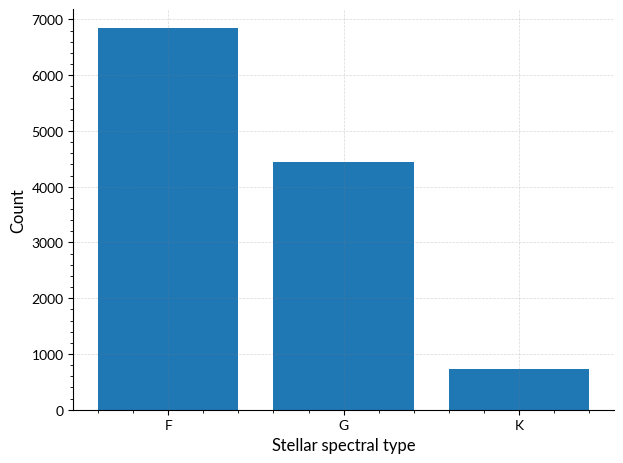

In [25]:
counts = Counter(star_types)
plt.bar(counts.keys(), counts.values(), width=0.8)
plt.xlabel("Stellar spectral type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

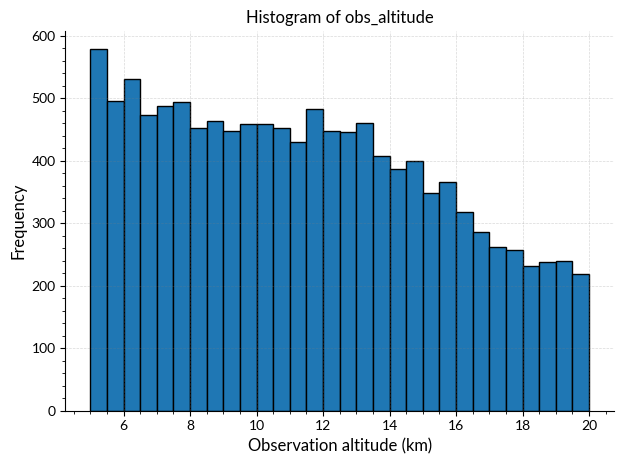

In [19]:
plt.hist(obs_altitude, bins=30, edgecolor="black")
plt.xlabel("Observation altitude (km)")
plt.ylabel("Frequency")
plt.title("Histogram of obs_altitude")
plt.tight_layout()
plt.show()